In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import os
import glob
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from unet import UNet
from tqdm import tqdm

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
print("pytorch versino:", torch.__version__)
print("use cuda:", use_cuda)

submission_number = "005"

pytorch versino: 0.4.0
use cuda: False


## Load Images

In [3]:

base_dir = "/floyd/input/data"
#base_dir = "../salt_data"
test_image_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
train_image_dir = os.path.join(train_dir, "images")
train_mask_dir = os.path.join(train_dir, "masks")

fname_train_images = glob.glob(os.path.join(train_image_dir, "*.png"))
fname_train_masks = glob.glob(os.path.join(train_mask_dir, "*.png"))
fname_test_images = glob.glob(os.path.join(test_image_dir, "*.png"))

train_ids = [os.path.split(fname)[1].replace(".png", "") for fname in fname_train_images]
test_ids = [os.path.split(fname)[1].replace(".png", "") for fname in fname_test_images]

print(len(fname_train_images), len(fname_train_masks), len(fname_test_images))
print(fname_train_images[:3])
print(fname_train_masks[:3])
print(fname_test_images[:3])
print(train_ids[:3])
print(test_ids[:3])

4000 4000 18000
['/floyd/input/data/train/images/455c8febce.png', '/floyd/input/data/train/images/7053b28de2.png', '/floyd/input/data/train/images/e12cf83477.png']
['/floyd/input/data/train/masks/455c8febce.png', '/floyd/input/data/train/masks/7053b28de2.png', '/floyd/input/data/train/masks/e12cf83477.png']
['/floyd/input/data/test/9431677217.png', '/floyd/input/data/test/d33fce2c44.png', '/floyd/input/data/test/0373bd8d6c.png']
['455c8febce', '7053b28de2', 'e12cf83477']
['9431677217', 'd33fce2c44', '0373bd8d6c']


### confirm the image and mask are gray scale

(101, 101, 3)

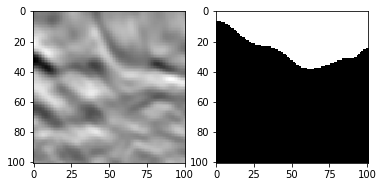

In [4]:
idx = 11
fname = fname_train_images[idx]
img = cv2.imread(fname)

fname = fname_train_masks[idx]
mask = cv2.imread(fname)
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)

img[1, 0, :], mask[1, 0, :]
img.shape

## depth distribution and classification

In [12]:
train_df = pd.read_csv(os.path.join(base_dir, "train.csv"), index_col="id", usecols=[0])
depth_df = pd.read_csv(os.path.join(base_dir, "depths.csv"), index_col="id")
train_df = train_df.join(depth_df)
test_df = depth_df[~depth_df.index.isin(train_df.index)]

train_df.head()

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [13]:
test_df.head()

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [5]:
org_size = (1, 101, 101)
upsample_size = (1, 128, 128)

def load_image(path):
    img = cv2.imread(path)
    img = img[:, :, 0:1] # take only 1 channel because every channel has same values
    img = np.transpose(img, (2, 0, 1))
    img = img/255
    
    return img


class Resizing:
    def __init__(self, left, right, top, bottom):
        
        self.m = nn.ReflectionPad2d((left, right, top, bottom))
        
        # for slicing
        self.top = top
        self.bottom = -bottom if bottom != 0 else None # 0 not work in slice in unpad function
        self.left = left
        self.right = -right if right != 0 else None
        
    def pad(self, imgs):
        return self.m(imgs)
    
    def unpad(self, imgs):
        return imgs[:, :, self.top:self.bottom, self.left:self.right]

    
size_diff = 128 - 101
pad_size_left = size_diff // 2
pad_size_right = size_diff // 2 + size_diff % 2
pad_size_top = pad_size_left
pad_size_bottom = pad_size_right
print(pad_size_left, pad_size_right, pad_size_top, pad_size_bottom)

a = torch.arange(25).reshape(1,1,5,5)
rs = Resizing(0, 1, 0, 2)
b = rs.pad(a)
rs.unpad(b)


13 14 13 14


tensor([[[[  0.,   1.,   2.,   3.,   4.],
          [  5.,   6.,   7.,   8.,   9.],
          [ 10.,  11.,  12.,  13.,  14.],
          [ 15.,  16.,  17.,  18.,  19.],
          [ 20.,  21.,  22.,  23.,  24.]]]])

In [6]:


class SaltDataset(Dataset):
    def __init__(self, root_path, file_ids, is_test=False):
        self.root_path = root_path
        self.file_ids = file_ids
        self.is_test = is_test
    
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, idx):
        
        file_id = self.file_ids[idx]
        
        if self.is_test:
            image_folder = self.root_path
        else:
            image_folder = os.path.join(self.root_path, "images")
        
        image_path = os.path.join(image_folder, file_id + ".png")
        
        img = load_image(image_path)
        img = img.astype(np.float32)
        
        if self.is_test:
            return img
        
        else:
            mask_folder = os.path.join(self.root_path, "masks")
            mask_path = os.path.join(mask_folder, file_id + ".png")
            mask = load_image(mask_path)
            mask = mask.astype(np.float32)

            return img, mask
        
    
    

In [7]:
def train(model, device, data_loader, loss_fn, optimizer, pad_f):
    train_loss = []
    model.train()
    
    for image, mask in tqdm(data_loader):
        image, mask = image.to(device), mask.to(device)
        image = pad_f(image)
        mask = pad_f(mask)
        
        y_pred = model(image)
        loss = loss_fn(y_pred, mask)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    
    return np.mean(train_loss)


def validation(model, device, data_loader, loss_fn, pad_f):
    val_loss = []
    model.eval()
    
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            image = pad_f(image)
            mask = pad_f(mask)
            
            y_pred = model(image)

            loss = loss_fn(y_pred, mask)
            val_loss.append(loss.item())
    
    return np.mean(val_loss)

            

In [8]:
#train_ids = train_ids[:16*1]
val_id_list = train_ids[::5] 
train_id_list = [_id for _id in train_ids if _id not in val_id_list]

train_dataset = SaltDataset(train_dir, file_ids=train_id_list)
val_dataset = SaltDataset(train_dir, file_ids=val_id_list)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)



device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(num_class=1, input_channel=1, depth=5, start_filters=32).to(device)

learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epoch = 13

train_loss_list = []
val_loss_list = []

rs = Resizing(pad_size_left, pad_size_right, pad_size_top, pad_size_bottom)

100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


Epoch: 0, Train: 0.227, Val: 0.228


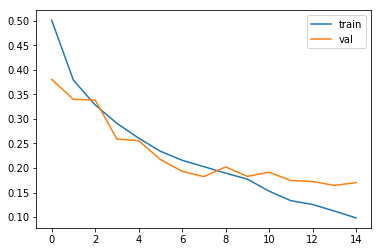

In [11]:
n_epoch = 1
for epoch in range(n_epoch):
    
    train_loss = train(model, device, train_data_loader, loss_fn, optimizer, rs.pad)
    train_loss_list.append(train_loss)
    
    val_loss = validation(model, device, val_data_loader, loss_fn, rs.pad)
    val_loss_list.append(val_loss)
    
    print("Epoch: %d, Train: %.3f, Val: %.3f" % (epoch, train_loss_list, val_loss_list))

plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
        

In [22]:
#torch.save(model.state_dict(), "model_%s" % submission_number)

### submission

In [9]:
#model.load_state_dict(torch.load("model"))

In [12]:
def rl_enc(img, order='F'):
    """Convert binary mask image to run-length array or string.
    
    Args:
    img: image in shape [n, m]
    order: is down-then-right, i.e. Fortran(F)
    string: return in string or array

    Return:
    run-length as a string: <start[1s] length[1s] ... ...>
    """
    bytez = img.reshape(img.shape[0] * img.shape[1], order=order)
    bytez = np.concatenate([[0], bytez, [0]])
    runs = np.where(bytez[1:] != bytez[:-1])[0] + 1 # pos start at 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Use for sanity check the encode function
def rl_dec(rl_string, shape=(101, 101), order='F'):
    """Convert run-length string to binary mask image.
    
    Args:
    rl_string: 
    shape: target shape of array
    order: decode order is down-then-right, i.e. Fortran(F)

    Return:
    binary mask image as array
    """
    s = rl_string.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order=order)

In [13]:
# https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification
def rlenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [14]:


def test(model, device, data_loader, threshold, pad_f, unpad_f):
    model.eval()
    
    y_pred_all = []
    
    with torch.no_grad():
        
        for img in tqdm(data_loader):
            img = img.to(device)
            img = pad_f(img)
            
            y_pred = model(img)
            
            y_pred = unpad_f(y_pred)
            
            y_pred[y_pred >= threshold] = 1
            y_pred[y_pred < threshold] = 0
            
            y_pred_all.append(y_pred)
            
    
    
    y_pred_all = torch.cat(y_pred_all)
    y_pred_all = torch.squeeze(y_pred_all)
    
    return y_pred_all

def compute_iou(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum((y_pred + y_true) > 0)
    
    return intersection / max(1e-9, union)


def compute_mean_iou(y_preds, y_trues):
    return np.mean([compute_iou(y_pred, y_true) for y_pred, y_true in zip(y_preds, y_trues)])


def return_predicts_and_trues(model, device, data_loader, pad_f, unpad_f):
    """returns original size(nx101x101), not padded size(nx128x128), where n is # of data.
    """
    y_pred_all = []
    y_true_all = []
    model.eval()
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            image = pad_f(image)
            
            y_pred = model(image)
            y_pred = unpad_f(y_pred)
            
            y_pred_all.append(y_pred)
            y_true_all.append(mask)
    
    
    y_pred_all = torch.cat(y_pred_all)
    y_pred_all = torch.squeeze(y_pred_all)
    
    y_true_all = torch.cat(y_true_all)
    y_true_all = torch.squeeze(y_true_all)

    return y_pred_all, y_true_all


def threshold_predictions(y_pred, threshold):
    ret = y_pred.clone()
    ret[y_pred >= threshold] = 1
    ret[y_pred < threshold] = 0

    return ret
    


### determin best threshold from validation set

0.1708860759493671


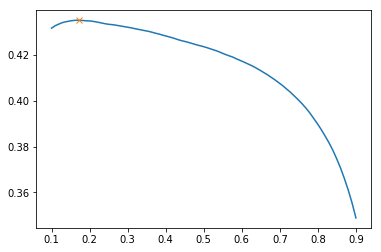

In [15]:
thresholds = np.linspace(0.1, 0.9, 80)

y_preds, y_trues = return_predicts_and_trues(model, device, val_data_loader, rs.pad, rs.unpad)
mean_ious = []
for th in thresholds:
    mask = threshold_predictions(y_preds, th)
    mean_ious.append(compute_mean_iou(mask.cpu().numpy(), y_trues.cpu().numpy()))

max_th_index = np.argmax(mean_ious)
max_threshold = thresholds[max_th_index]
max_iou = mean_ious[max_th_index]
plt.plot(thresholds, mean_ious)
plt.plot([max_threshold], [max_iou], 'x')
print(max_threshold, )

In [16]:

test_dataset = SaltDataset(test_image_dir, file_ids=test_ids, is_test=True)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
y_pred_all = test(model, device, test_data_loader, max_threshold, rs.pad, rs.unpad)

masks_all = y_pred_all.cpu().numpy()
np.save("masks_all.npy", masks_all)


100%|██████████| 71/71 [01:42<00:00,  1.45s/it]


In [ ]:
#masks_all = np.load("masks_all.npy")

In [18]:
with open("submission_%s.csv" % submission_number, 'w') as f:
    f.write("id, rle_mask\n")
    for idx, mask in tqdm(zip(test_ids, masks_all)):
        f.write("%s, %s\n" % (idx, rl_enc(mask)))

18000it [00:02, 7652.82it/s]
